In [1]:
import numpy as np
from tsaugmentation.transformations.compute_similarities import ComputeSimilarities
from tsaugmentation.transformations.similarity_model import SimilarityModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.rcParams.update({'font.size': 22})

In [2]:
versions = 6
transformations = ['jitter', 'scaling', 'magnitude_warp', 'time_warp']

In [3]:
orig = np.load('../data/transformed_datasets/tourism_original.npy')
transf = []
for t in transformations:
    transf_ = []
    for v in range(1, versions+1):
        transf_.append(np.load(f'../data/transformed_datasets/tourism_version_{v}_10samples_single_transf_{t}.npy'))
    transf.append(transf_)

In [11]:
transf = np.array(transf)

In [12]:
# Compute distance between original version and transformed version
avg_sim_base_transf = []
for t in range(len(transformations)):
    avg_transf = []
    for v in range(versions):
        avg_sample = []
        for s in range(transf[t][v].shape[0]):
            avg_sample.append(ComputeSimilarities(dataset=orig, transf_dataset=transf[t][v][s]) \
                .compute_mean_similarity_elementwise())
        avg_transf.append(avg_sample)
    avg_sim_base_transf.append(avg_transf)

In [13]:
df_ = np.array(avg_sim_base_transf)

In [29]:
transformation = np.array(transformations)
version = np.array(np.arange(versions))
sample = np.array(np.arange(10))
cols = pd.MultiIndex.from_product([transformation, version, sample])
df = pd.DataFrame(df_.reshape(1, -1), columns=cols).melt(var_name=['transformation', 'version', 'sample'])

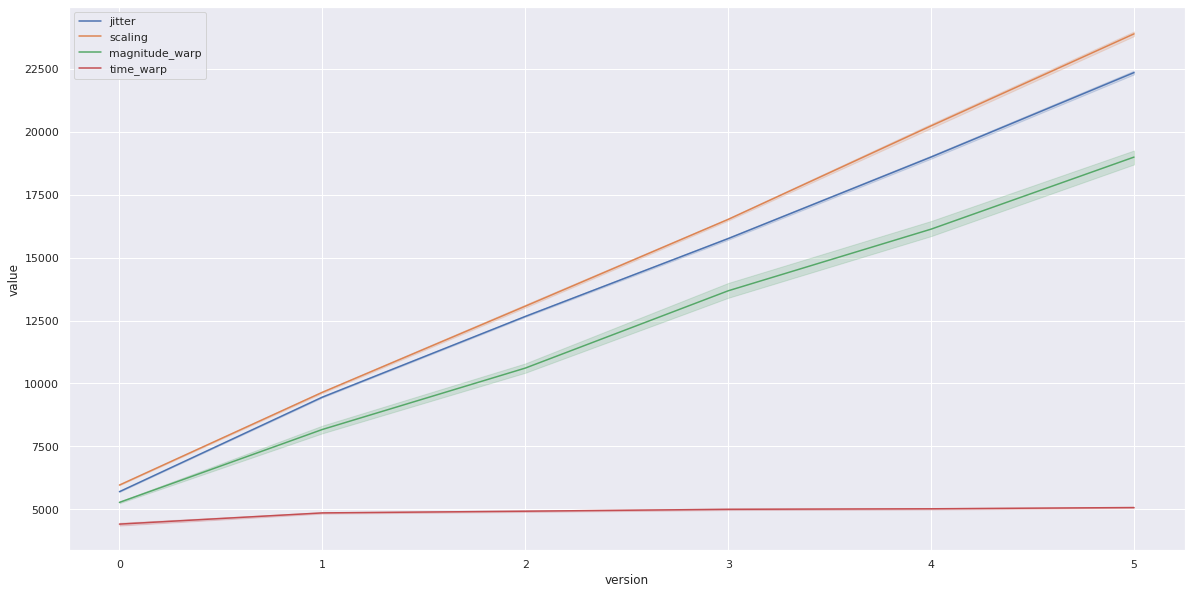

In [30]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))

fg = sns.lineplot(x='version', 
                  y='value',
                  hue='transformation',
                  data=df, 
                  ax=ax)    
plt.legend()
plt.show()

In [39]:
# Compute distance intra each version and compare distributions between versions

# Compute distance between series in the original dataset
orig_dist = []
for i in range(orig.shape[1]):
    orig_dist.append(ComputeSimilarities(dataset=orig, transf_series=orig[:,i]) \
                    .compute_similarity_single_series_and_dataset())

In [ ]:
dist_base_transf = []
for t in range(len(transformations)):
    transf_dist = []
    for v in range(versions):
        sample_dist = []
        for s in range(transf[t][v].shape[0]):
            series_dist = []
            for i in range(transf[t][v][s].shape[1]):
                series_dist.append(ComputeSimilarities(dataset=orig, transf_series=transf[t][v][s][:,i]) \
                                    .compute_similarity_single_series_and_dataset())
            sample_dist.append(series_dist)
        transf_dist.append(sample_dist)
    dist_base_transf.append(transf_dist)